In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame 
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import pandas_datareader as web
!pip install plotly
import plotly.graph_objects as go

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [2]:
def dataExtract(startDate,outputFile):
  try:
    data = pd.read_pickle(outputFile)
    print('File data found...reading CrudeOil data')
  except FileNotFoundError:
    print('File not found...downloading CrudeOil data')
    data = web.DataReader('CL=F', 'yahoo', startDate)
    data.to_pickle(outputFile)
  return data

data = dataExtract(startDate='2010-01-01', outputFile='CrudeOilPrice.pkl')
print(data.head())

File data found...reading CrudeOil data
                 High        Low       Open      Close    Volume  Adj Close
Date                                                                       
2010-01-04  81.680000  79.629997  79.629997  81.510002  263542.0  81.510002
2010-01-05  82.000000  80.949997  81.629997  81.769997  258887.0  81.769997
2010-01-06  83.519997  80.849998  81.430000  83.180000  370059.0  83.180000
2010-01-07  83.360001  82.260002  83.199997  82.660004  246632.0  82.660004
2010-01-08  83.470001  81.800003  82.650002  82.750000  310377.0  82.750000


In [3]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-17,65.339996,63.599998,64.750000,64.599998,254724.0,64.599998
2021-03-18,64.820000,58.200001,64.419998,60.000000,143597.0,60.000000
2021-03-19,61.720001,58.939999,59.560001,61.419998,84171.0,61.419998
2021-03-22,61.900002,60.389999,61.549999,61.549999,84171.0,61.549999
2021-03-23,61.349998,58.470001,61.549999,59.279999,155168.0,59.279999


In [4]:
def MACrossOver(data, shortWindow, longWindow):
  signals = pd.DataFrame(index=data.index)
  signals['tradeSignal'] = 0.0
  signals['MA20'] = data['Close'].rolling(window=shortWindow, 
                                                min_periods=1, center=False).mean()
  signals['MA100'] = data['Close'].rolling(window=longWindow, 
                                                         min_periods=1, center=False).mean()
  signals['tradeSignal'][shortWindow:] = np.where(signals['MA20'][shortWindow:] > signals['MA100'][shortWindow:], 1.0, 0.0)
  signals['finalSignal'] = signals['tradeSignal'].diff()
  return signals

newSeries = MACrossOver(data,20,100)

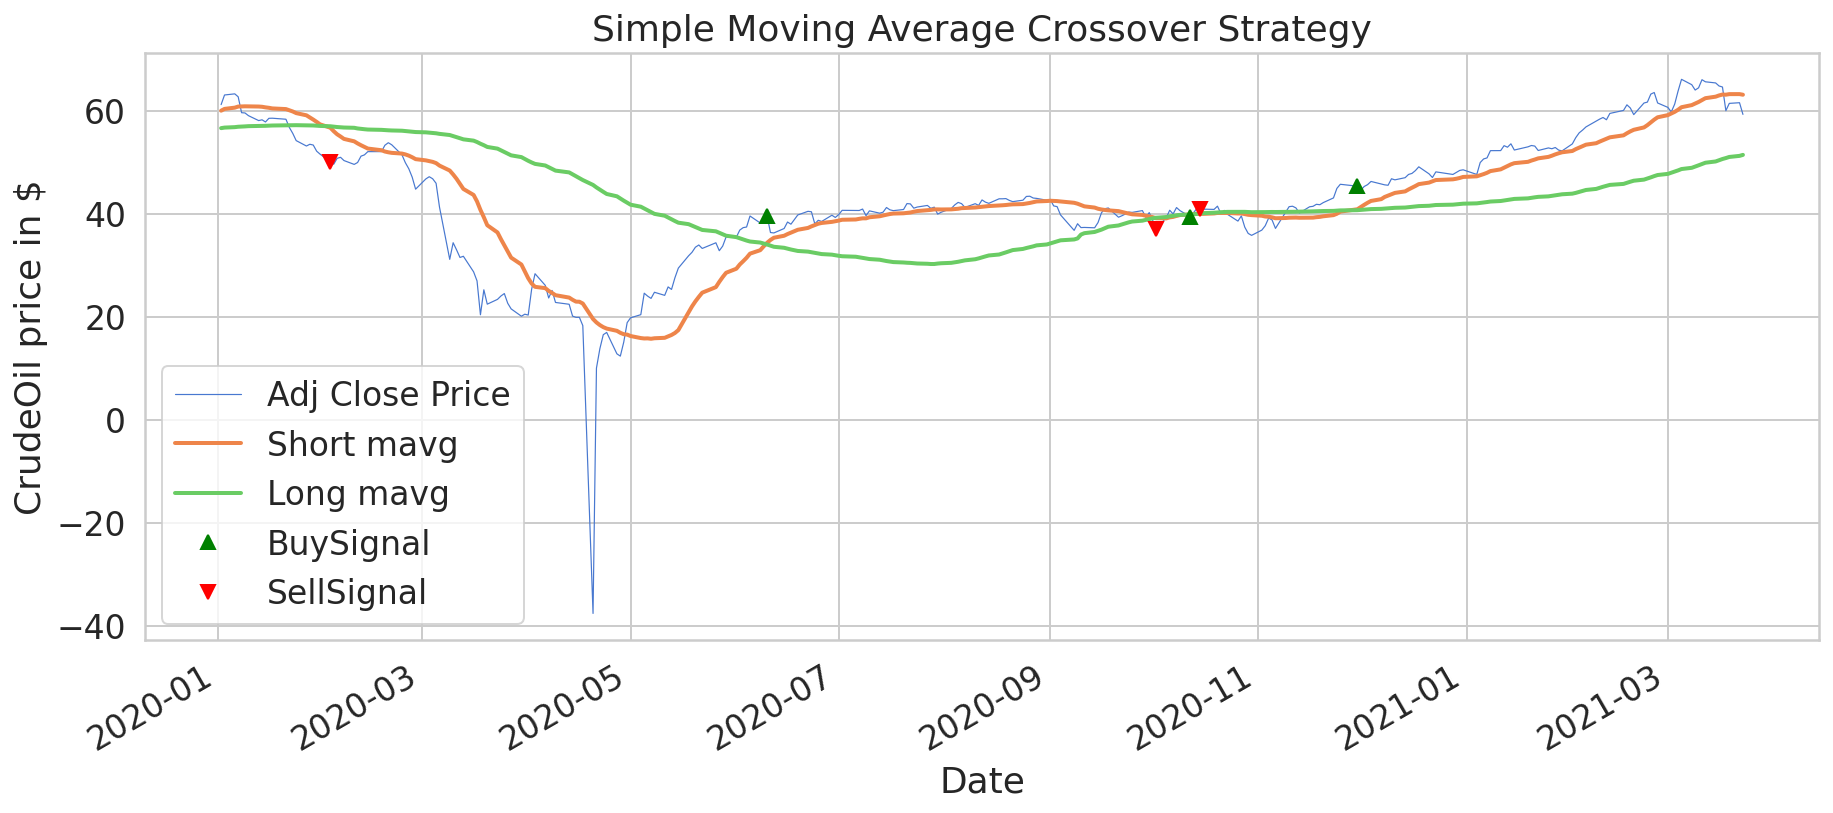

In [5]:
newSeries = newSeries['2020-01-01':]
DATA = data['2020-01-01':]
fig = plt.figure(figsize= (15,6))
ax1 = fig.add_subplot(111, ylabel='CrudeOil price in $')
DATA["Adj Close"].plot(ax=ax1, lw=.6)
newSeries["MA20"].plot(ax=ax1, lw=2.)
newSeries["MA100"].plot(ax=ax1,  lw=2.)
ax1.plot(newSeries.loc[newSeries.finalSignal== 1.0].index, DATA["Adj Close"][newSeries.finalSignal == 1.0],'^', markersize=7, color='green')
ax1.plot(newSeries.loc[newSeries.finalSignal== -1.0].index, DATA["Adj Close"][newSeries.finalSignal == -1.0],'v', markersize=7, color='red')
plt.legend(["Adj Close Price","Short mavg","Long mavg","BuySignal","SellSignal"])
plt.title("Simple Moving Average Crossover Strategy")
plt.show()

## Implementation of the exponential moving average
EMA, is widely used technical analysis indicator for time series data. EMA places more weight on the recent price observation and less weight
on the older price observations. This intuition is that the new price observation has more up-to-date information than the past. 

We will implement EMA with 20 days and 10 days as the number of time
periods to compute the average over. The default smoothing factor of 2 / (n + 1)
for this implementation. 

In [6]:
data['ema5'] = (data['Adj Close'].ewm(span=5,adjust=True,ignore_na=True).mean())
data['ema20'] = (data['Adj Close'].ewm(span=20,adjust=True,ignore_na=True).mean())
data.dropna(inplace=True)


In [7]:
t = data['2020-01-01':].copy()
fig = go.Figure(data=[go.Candlestick(x=t.index,
                                     open=t['Open'],
                                     high=t['High'],
                                     low=t['Low'],
                                     close=t['Adj Close'])])
fig.add_trace(go.Scatter(x = t.index, y = t.ema5, marker = dict(
        color = "blue"), name = "EMA5"))
fig.add_trace(go.Scatter(x = t.index, y = t.ema20, marker = dict(
        color = "gray"), name = "EMA20"))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(autosize = False, width = 1200, height = 600,)
fig.update_layout(title='Candlestick plot::Crude oil prices', yaxis_title='(US$)')
fig.show()

In [8]:
from sklearn import metrics, preprocessing

In [9]:
def classificationFeatures(data):
  data['CloseR'] = data['Adj Close'].pct_change()
  data['LowR'] = data.Low.pct_change()
  data['HighR'] = data.High.pct_change()
  data['VolumeR'] = data.Volume.pct_change()
  data['dailyChange'] = (data['Adj Close'] - data['Open']) / data['Open']
  # data['ema10'] = data['ema10']
  # data['ema20'] = data.ema20
  data['oc'] = (data['Open'] - data['Adj Close'])
  data['hl'] = (data['High'] - data['Low'])
  data['target'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)
  data = data.replace([np.inf, -np.inf], np.nan)
  data = data.dropna()
  return data

data = classificationFeatures(data)
# X = preprocessing.scale(X)
storeDf = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]

In this code, the following applies:
The classification response variable is +1 if the close price tomorrow is higher than the close price today, and -1 if the close price tomorrow is lower than the close price today.
For this example, we assume that the close price tomorrow is not the same as the close price today, which we can choose to handle by creating a third categorical value, 0.

In [10]:
def features():
    X =  data[['oc', 'hl', 'LowR', 'HighR', 'VolumeR']]
    Y = data.target
    return X,Y
X,Y = features()

In [11]:
Y

Date
2010-01-05    1
2010-01-06    0
2010-01-07    1
2010-01-08    0
2010-01-11    0
             ..
2021-03-17    0
2021-03-18    1
2021-03-19    1
2021-03-22    0
2021-03-23    0
Name: target, Length: 2800, dtype: int64

In [12]:
pip install tscv

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from tscv import GapKFold

gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
# tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in gkcv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.values[train_index], X.values[test_index]
  y_train, y_test = Y[train_index], Y[test_index]

print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

Length train set: 2238
Length test set: 560


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [15]:
# Create models
print("Accuracy scores/Confusion Matrices:\n")
models = [("LR", LogisticRegression(penalty='l2',random_state = 0)),
          ("LDA", LinearDiscriminantAnalysis()),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LSVC", LinearSVC()),
          ("RF", RandomForestClassifier(bootstrap=True,
                                        ccp_alpha=0.0,
                                        class_weight="balanced",
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000,
                                        
                                        
                                        random_state=0,
                                        
                                        
                                        
                                        verbose=0,
                                        warm_start=False))]
# iterate over the models
for m in models:
    # Train each of the models on the training set
    m[1].fit(X_train, y_train)
    # predictions on the test set
    pred = m[1].predict(X_test)
    # Accuracy Score and the confusion matrix for each model
    print("%s:\n%0.3f" % (m[0], m[1].score(X_test, y_test)))
    print("%s\n" % confusion_matrix(pred, y_test))


Accuracy scores/Confusion Matrices:

LR:
0.495
[[101 125]
 [158 176]]

LDA:
0.495
[[ 96 120]
 [163 181]]

QDA:
0.504
[[209 228]
 [ 50  73]]



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LSVC:
0.496
[[ 95 118]
 [164 183]]

RF:
0.539
[[124 123]
 [135 178]]



In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

LR = QuadraticDiscriminantAnalysis()
RF = RandomForestClassifier(bootstrap=True,
                            ccp_alpha=0.0,
                            class_weight="balanced",
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            n_estimators=1000,
                            random_state=0,
                            verbose=0,
                            warm_start=False)

ensembleClassifiers = VotingClassifier(
    estimators=[
                ('RF', RF), 
                ('LR', LR)
                ],
    voting='hard'
    ).fit(X, Y)

ensembleScore = cross_val_score(ensembleClassifiers, X, Y, cv=gkcv).mean()
ensembleScore

0.495

In [17]:
RF = RandomForestClassifier(bootstrap=True,
                            ccp_alpha=0.0,
                            class_weight="balanced",
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            n_estimators=1000,
                            random_state=0,
                            verbose=0,
                            warm_start=False).fit(X,Y)
Score = cross_val_score(RF, X, Y, cv=gkcv).mean()
Score

0.5142857142857142

In [22]:
storeDf['PredictedSignal'] = (RF.predict(X))
storeDf['finalSignal'] = storeDf['PredictedSignal'].diff()
print(storeDf)
print('Number of trades (buy) = ', (storeDf['PredictedSignal']==1).sum())
print('Number of trades (sell) = ', (storeDf['PredictedSignal']==0).sum())
print()
print('Number of trades (buy) = ', (storeDf['finalSignal']==1).sum())
print('Number of trades (sell) = ', (storeDf['finalSignal']==-1).sum())

                 Open       High  ...  PredictedSignal  finalSignal
Date                              ...                              
2010-01-05  81.629997  82.000000  ...                1          NaN
2010-01-06  81.430000  83.519997  ...                0         -1.0
2010-01-07  83.199997  83.360001  ...                1          1.0
2010-01-08  82.650002  83.470001  ...                0         -1.0
2010-01-11  82.879997  83.949997  ...                0          0.0
...               ...        ...  ...              ...          ...
2021-03-17  64.750000  65.339996  ...                0          0.0
2021-03-18  64.419998  64.820000  ...                1          1.0
2021-03-19  59.560001  61.720001  ...                1          0.0
2021-03-22  61.549999  61.900002  ...                0         -1.0
2021-03-23  61.549999  61.349998  ...                0          0.0

[2800 rows x 7 columns]
Number of trades (buy) =  1443
Number of trades (sell) =  1357

Number of trades (buy) =  7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 0.0    33
-1.0    11
 1.0    11
Name: finalSignal, dtype: int64


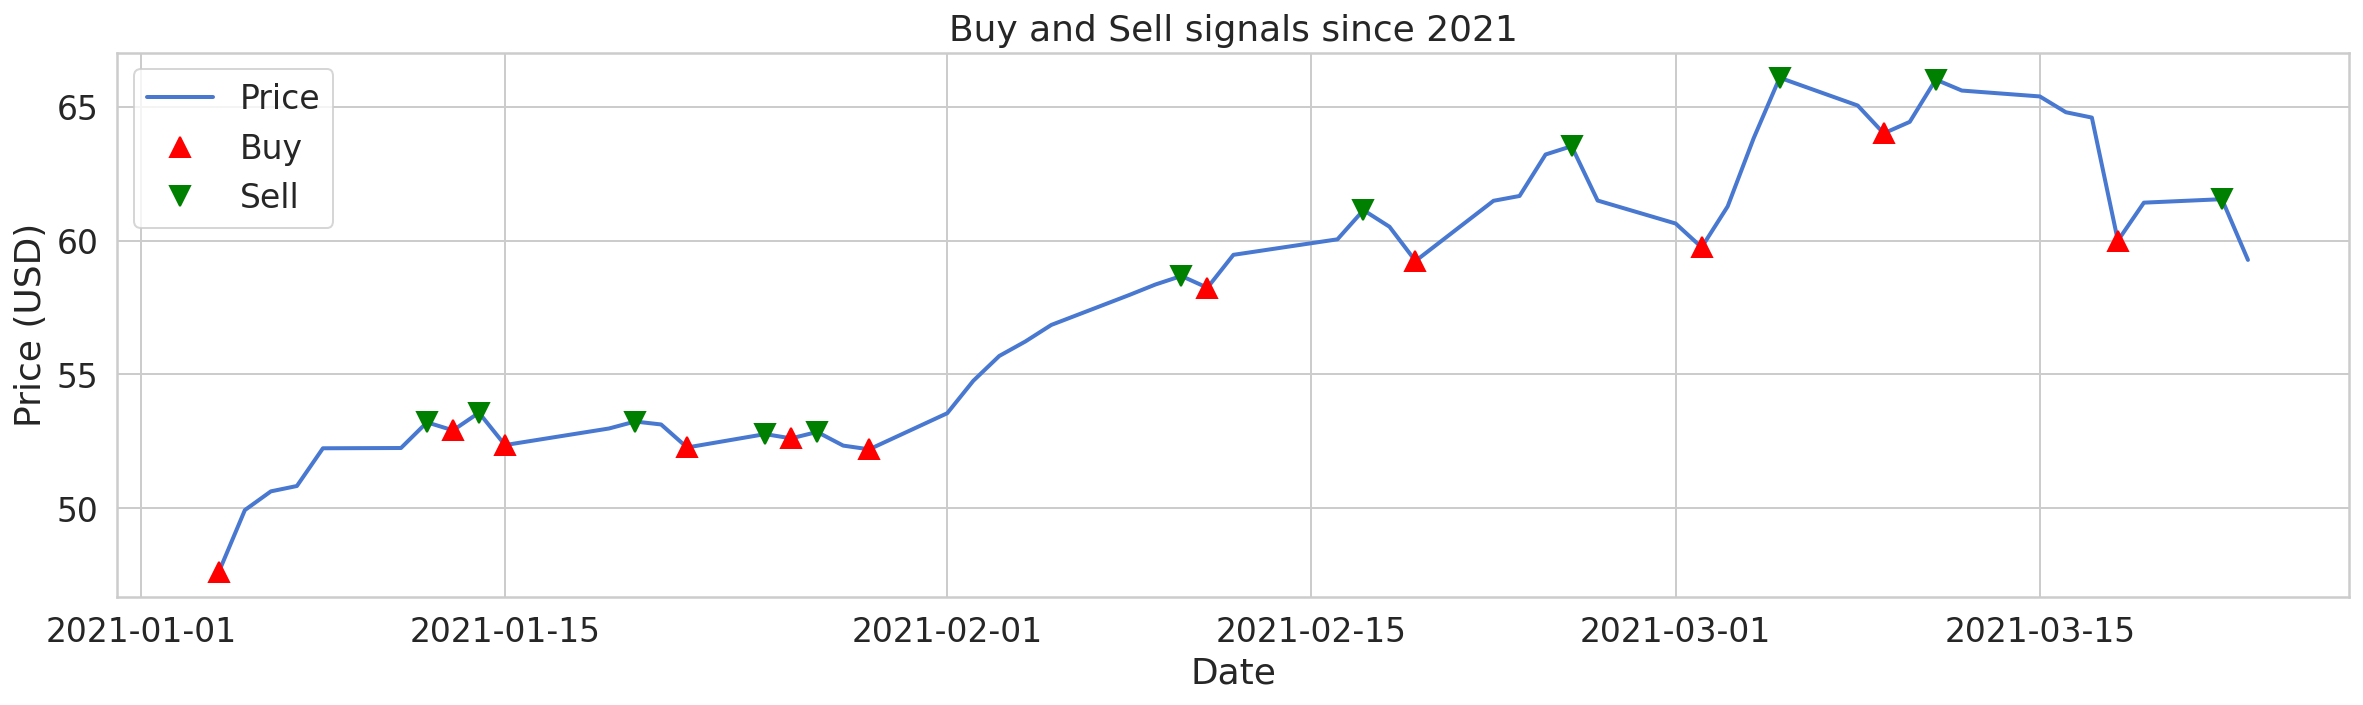

In [23]:
%matplotlib inline

plotDf = storeDf['2021-01-01':]
print(plotDf.finalSignal.value_counts())

# Buy/Sell signals plot
buys = plotDf.loc[plotDf["finalSignal"] == 1];
sells = plotDf.loc[plotDf["finalSignal"] == -1];
# Plot
fig = plt.figure(figsize=(20, 5));
plt.plot(plotDf.index, plotDf['Adj Close'], lw=2., label='Price');
# Plot buy and sell signals
# up arrow when we buy one share
plt.plot(buys.index, plotDf.loc[buys.index]['Adj Close'], '^', markersize=10, color='red', lw=2., label='Buy');
# down arrow when we sell one share
plt.plot(sells.index, plotDf.loc[sells.index]['Adj Close'], 'v', markersize = 10, color='green', lw=2., label='Sell');
plt.ylabel('Price (USD)'); plt.xlabel('Date');
plt.title('Buy and Sell signals since 2021'); plt.legend(loc='best');
plt.show()

File data found...reading CrudeOil data


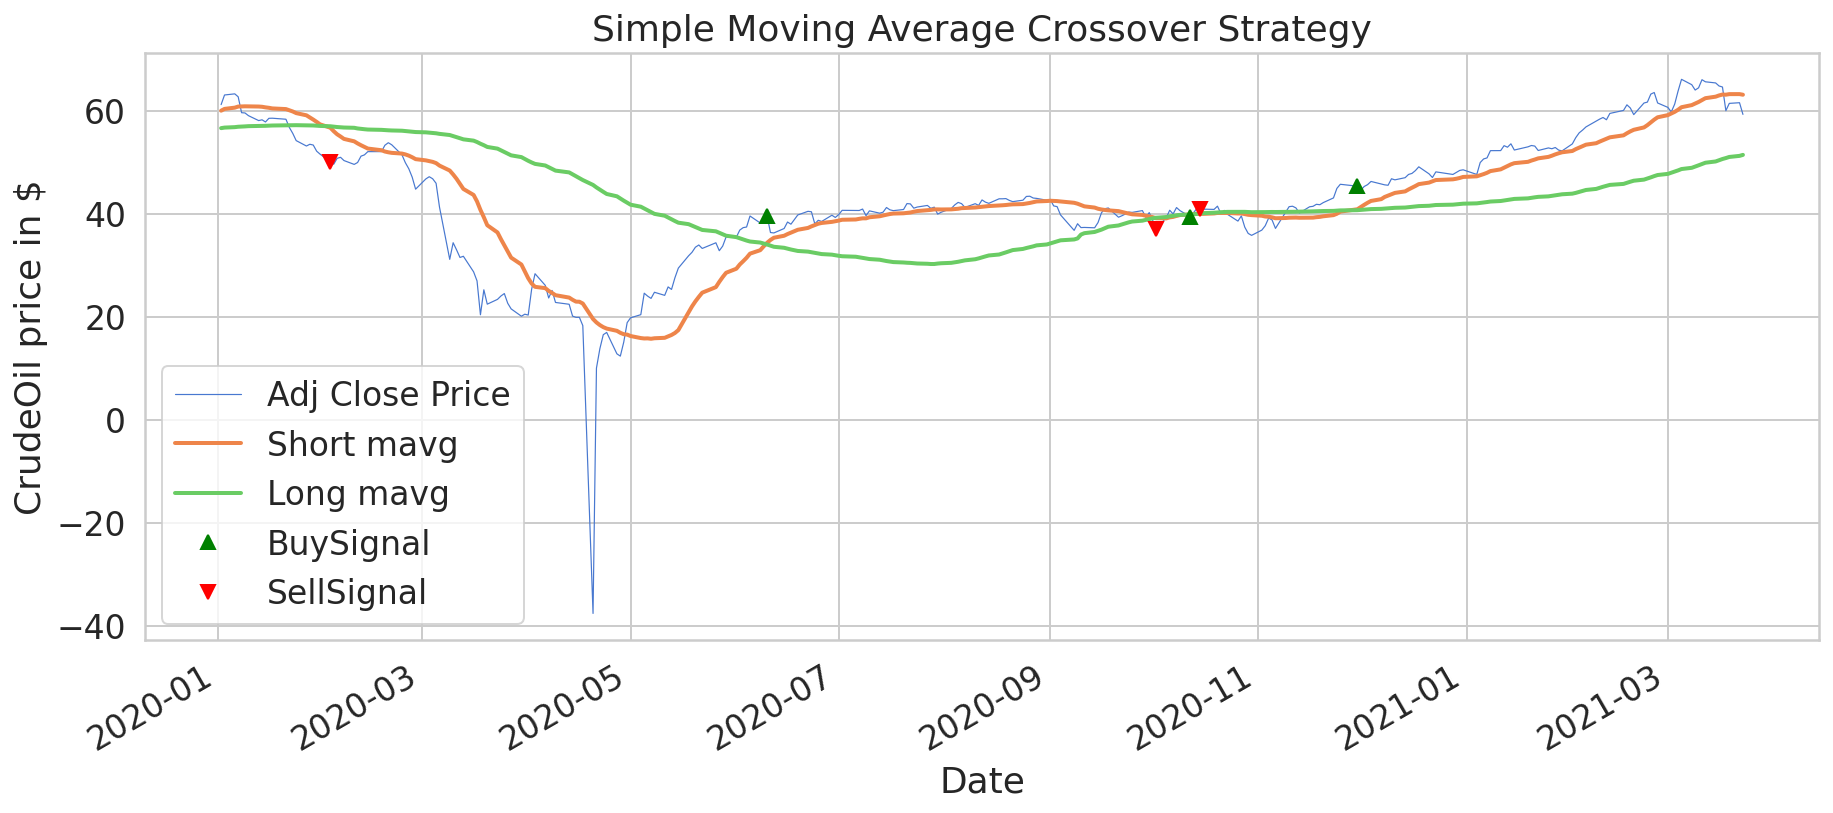

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 0.0    33
-1.0    11
 1.0    11
Name: finalSignal, dtype: int64


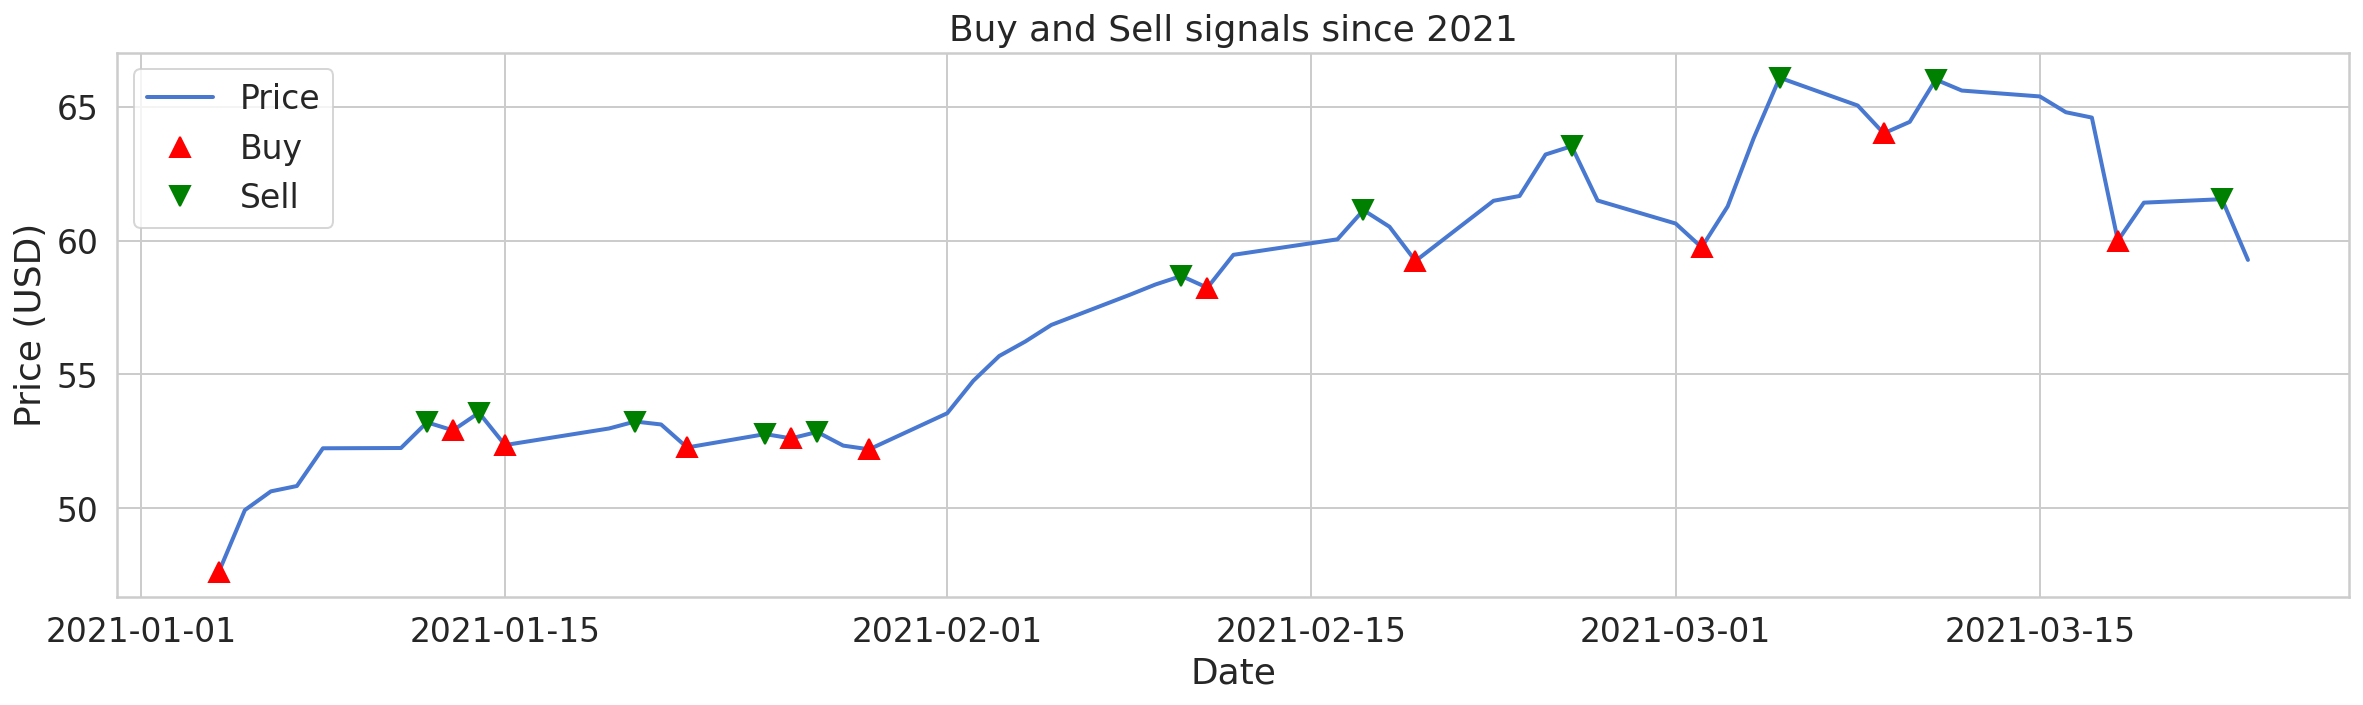

In [28]:
def dataExtract(startDate,outputFile):
  try:
    data = pd.read_pickle(outputFile)
    print('File data found...reading CrudeOil data')
  except FileNotFoundError:
    print('File not found...downloading CrudeOil data')
    data = web.DataReader('CL=F', 'yahoo', startDate)
    data.to_pickle(outputFile)
  return data

data = dataExtract(startDate='2010-01-01', outputFile='CrudeOilPrice.pkl')

def MACrossOver(data, shortWindow, longWindow):
  signals = pd.DataFrame(index=data.index)
  signals['tradeSignal'] = 0.0
  signals['MA20'] = data['Close'].rolling(window=shortWindow, 
                                                min_periods=1, center=False).mean()
  signals['MA100'] = data['Close'].rolling(window=longWindow, 
                                                         min_periods=1, center=False).mean()
  signals['tradeSignal'][shortWindow:] = np.where(signals['MA20'][shortWindow:] > signals['MA100'][shortWindow:], 1.0, 0.0)
  signals['finalSignal'] = signals['tradeSignal'].diff()
  return signals

newSeries = MACrossOver(data,20,100)

newSeries = newSeries['2020-01-01':]
DATA = data['2020-01-01':]
fig = plt.figure(figsize= (15,6))
ax1 = fig.add_subplot(111, ylabel='CrudeOil price in $')
DATA["Adj Close"].plot(ax=ax1, lw=.6)
newSeries["MA20"].plot(ax=ax1, lw=2.)
newSeries["MA100"].plot(ax=ax1,  lw=2.)
ax1.plot(newSeries.loc[newSeries.finalSignal== 1.0].index, DATA["Adj Close"][newSeries.finalSignal == 1.0],'^', markersize=7, color='green')
ax1.plot(newSeries.loc[newSeries.finalSignal== -1.0].index, DATA["Adj Close"][newSeries.finalSignal == -1.0],'v', markersize=7, color='red')
plt.legend(["Adj Close Price","Short mavg","Long mavg","BuySignal","SellSignal"])
plt.title("Simple Moving Average Crossover Strategy")
plt.show()

data['ema5'] = (data['Adj Close'].ewm(span=5,adjust=True,ignore_na=True).mean())
data['ema20'] = (data['Adj Close'].ewm(span=20,adjust=True,ignore_na=True).mean())
data.dropna(inplace=True)

def plot():
  t = data['2020-01-01':].copy()
  fig = go.Figure(data=[go.Candlestick(x=t.index,
                                      open=t['Open'],
                                      high=t['High'],
                                      low=t['Low'],
                                      close=t['Adj Close'])])
  fig.add_trace(go.Scatter(x = t.index, y = t.ema5, marker = dict(
          color = "blue"), name = "EMA5"))
  fig.add_trace(go.Scatter(x = t.index, y = t.ema20, marker = dict(
          color = "gray"), name = "EMA20"))
  fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
  fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
  fig.update_layout(autosize = False, width = 1200, height = 600,)
  fig.update_layout(title='Candlestick plot::Crude oil prices', yaxis_title='(US$)')
  return fig

fig = plot()
fig.show()

def classificationFeatures(data):
  data['CloseR'] = data['Adj Close'].pct_change()
  data['LowR'] = data.Low.pct_change()
  data['HighR'] = data.High.pct_change()
  data['VolumeR'] = data.Volume.pct_change()
  data['dailyChange'] = (data['Adj Close'] - data['Open']) / data['Open']
  data['oc'] = (data['Open'] - data['Adj Close'])
  data['hl'] = (data['High'] - data['Low'])
  data['target'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)
  data = data.replace([np.inf, -np.inf], np.nan)
  data = data.dropna()
  return data

data = classificationFeatures(data)
storeDf = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]

def features():
    X =  data[['oc', 'hl', 'LowR', 'HighR', 'VolumeR']]
    Y = data.target
    return X,Y
X,Y = features()

gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
for train_index, test_index in gkcv.split(X):
  X_train, X_test = X.values[train_index], X.values[test_index]
  y_train, y_test = Y[train_index], Y[test_index]

RF = RandomForestClassifier(bootstrap=True,
                            ccp_alpha=0.0,
                            class_weight="balanced",
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            n_estimators=1000,
                            random_state=0,
                            verbose=0,
                            warm_start=False).fit(X,Y)
Score = cross_val_score(RF, X, Y, cv=gkcv).mean()

storeDf['PredictedSignal'] = (RF.predict(X))
storeDf['finalSignal'] = storeDf['PredictedSignal'].diff()

plotDf = storeDf['2021-01-01':]
print(plotDf.finalSignal.value_counts())

# Buy/Sell signals plot
buys = plotDf.loc[plotDf["finalSignal"] == 1];
sells = plotDf.loc[plotDf["finalSignal"] == -1];
# Plot
fig = plt.figure(figsize=(20, 5));
plt.plot(plotDf.index, plotDf['Adj Close'], lw=2., label='Price');
# Plot buy and sell signals
# up arrow when we buy one share
plt.plot(buys.index, plotDf.loc[buys.index]['Adj Close'], '^', markersize=10, color='red', lw=2., label='Buy');
# down arrow when we sell one share
plt.plot(sells.index, plotDf.loc[sells.index]['Adj Close'], 'v', markersize = 10, color='green', lw=2., label='Sell');
plt.ylabel('Price (USD)'); plt.xlabel('Date');
plt.title('Buy and Sell signals since 2021'); plt.legend(loc='best');
plt.show()